In [11]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as func
from pyspark.sql.types import DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = "student_lifestyle_dataset.csv"

spark = SparkSession.builder.appName("A5").getOrCreate()
df = spark.read.csv(path, header=True, inferSchema=True)
# Columns Available:
#    Student_ID
#    Study_Hours_Per_Day
#    Extracurricular_Hours_Per_Day
#    Sleep_Hours_Per_Day
#    Social_Hours_Per_Day
#    Physical_Activity_Hours_Per_Day
#    Stress_Level
#    Gender
#    Grades
df.select("Student_ID", "Study_Hours_Per_Day", "Extracurricular_Hours_Per_Day", "Sleep_Hours_Per_Day", "Grades").show(5)

# Total number of entries:
print(f"""There are {df.count()} rows and {len(df.columns)} columns in this dataset.""")

+----------+-------------------+-----------------------------+-------------------+------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Grades|
+----------+-------------------+-----------------------------+-------------------+------+
|         1|                6.9|                          3.8|                8.7|  7.48|
|         2|                5.3|                          3.5|                8.0|  6.88|
|         3|                5.1|                          3.9|                9.2|  6.68|
|         4|                6.5|                          2.1|                7.2|   7.2|
|         5|                8.1|                          0.6|                6.5|  8.78|
+----------+-------------------+-----------------------------+-------------------+------+
only showing top 5 rows

There are 2000 rows and 9 columns in this dataset.


In [3]:
df = df.dropna(subset=[
    "Study_Hours_Per_Day", "Extracurricular_Hours_Per_Day",
    "Sleep_Hours_Per_Day", "Social_Hours_Per_Day",
    "Physical_Activity_Hours_Per_Day",
    "Grades", "Stress_Level", "Gender"
])

df = StringIndexer(inputCol="Gender", outputCol="GenderIndex", handleInvalid="keep") \
       .fit(df).transform(df)

df = StringIndexer(inputCol="Stress_Level", outputCol="StressIndex", handleInvalid="keep") \
       .fit(df).transform(df)

for c in [
    "Study_Hours_Per_Day", "Extracurricular_Hours_Per_Day", "Sleep_Hours_Per_Day",
    "Social_Hours_Per_Day", "Physical_Activity_Hours_Per_Day",
    "Grades"
]:
    df = df.withColumn(c, col(c).cast(DoubleType()))

for c in ["GenderIndex", "StressIndex"]:
    df = df.withColumn(c, col(c).cast(DoubleType()))

In [4]:
train, test = df.randomSplit([0.8, 0.2], seed=42)

cgpa_feats = [
    "Study_Hours_Per_Day", "Extracurricular_Hours_Per_Day", "Sleep_Hours_Per_Day",
    "Social_Hours_Per_Day", "Physical_Activity_Hours_Per_Day",
    "StressIndex", "GenderIndex"
]

assembler1 = VectorAssembler(inputCols=cgpa_feats, outputCol="features_cgpa", handleInvalid="skip")
train1 = assembler1.transform(train).withColumnRenamed("Grades", "label_cgpa")
test1  = assembler1.transform(test).withColumnRenamed("Grades", "label_cgpa")

dt1 = DecisionTreeRegressor(featuresCol="features_cgpa", labelCol="label_cgpa")
model1 = dt1.fit(train1)
pred1  = model1.transform(test1)

print(" CGPA Prediction Sample (test set):")
pred1.select("label_cgpa", "prediction").show(10)

rmse1 = RegressionEvaluator(labelCol="label_cgpa", predictionCol="prediction", metricName="rmse") \
         .evaluate(pred1)
print(f" CGPA RMSE value: {rmse1:.3f}")

 CGPA Prediction Sample (test set):
+----------+-----------------+
|label_cgpa|       prediction|
+----------+-----------------+
|      6.68|6.832812500000002|
|       7.7|7.826021505376343|
|      7.05|6.832812500000002|
|      7.18|6.832812500000002|
|      7.32|7.420241935483871|
|      7.12|7.119426229508196|
|      8.12|8.616223404255317|
|       7.8|8.428189655172412|
|      8.88|8.616223404255317|
|       6.5|6.832812500000002|
+----------+-----------------+
only showing top 10 rows

 CGPA RMSE value: 0.530


In [5]:
importances = model1.featureImportances.toArray()

feat_imps = list(zip(cgpa_feats, importances))
feat_imps_sorted = sorted(feat_imps, key=lambda x: x[1], reverse=True)

print("Feature importances for CGPA prediction:")
for feat, imp in feat_imps_sorted:
    print(f" {feat:<30} {imp:.3f}")

Feature importances for CGPA prediction:
 Study_Hours_Per_Day            0.943
 Sleep_Hours_Per_Day            0.019
 Extracurricular_Hours_Per_Day  0.017
 Social_Hours_Per_Day           0.014
 Physical_Activity_Hours_Per_Day 0.008
 StressIndex                    0.000
 GenderIndex                    0.000


In [6]:
# Establish Sleep, Social, and Academics Scores
# Sleep = Since there's only 1 sleep metric, that will determine sleep score.
# Social = Mean of extracurricular, social, and physical activity hours per day.
# Academics = Mean of study hours per day and grades.
# Scores are rounded to a max of 3 decimal places
df_scores = df.withColumns({'Sleep_Score': df.Sleep_Hours_Per_Day, 
                            'Social_Score': func.round(((df.Extracurricular_Hours_Per_Day + df.Social_Hours_Per_Day + df.Physical_Activity_Hours_Per_Day)/3), 3),
                            'Academics_Score': func.round(((df.Study_Hours_Per_Day + df.Grades)/2), 3)})

df_scores.select('Student_ID', 'Sleep_Score', 'Social_Score', 'Academics_Score').show(10)

+----------+-----------+------------+---------------+
|Student_ID|Sleep_Score|Social_Score|Academics_Score|
+----------+-----------+------------+---------------+
|         1|        8.7|         2.8|           7.19|
|         2|        8.0|       3.567|           6.09|
|         3|        9.2|       3.233|           5.89|
|         4|        7.2|       3.433|           6.85|
|         5|        6.5|       3.133|           8.44|
|         6|        8.0|       3.333|           6.56|
|         7|        5.3|       3.567|           7.85|
|         8|        5.6|       3.333|            8.2|
|         9|        6.3|       4.167|          6.125|
|        10|        9.8|       2.167|            7.3|
+----------+-----------+------------+---------------+
only showing top 10 rows



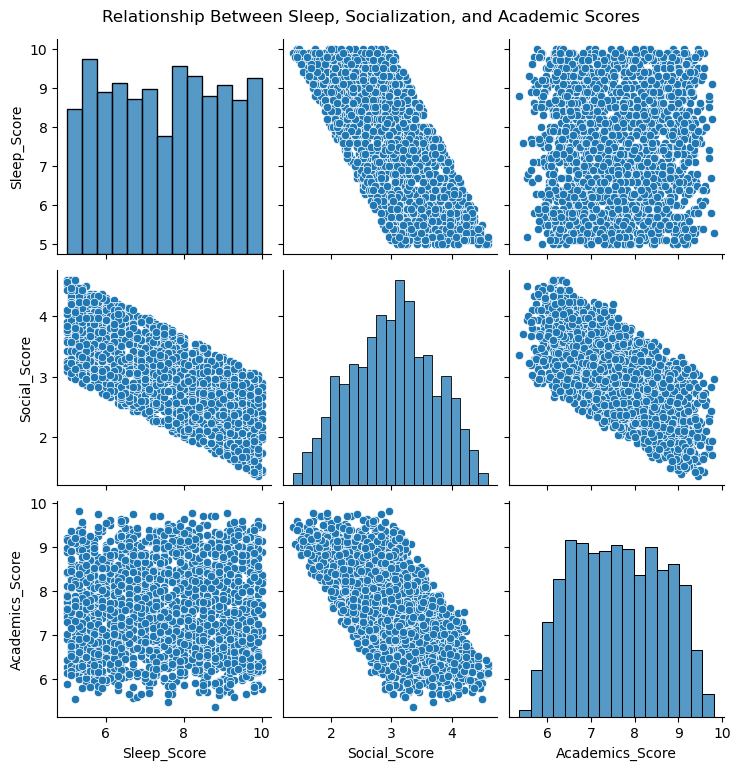

In [7]:
# Visualize the data
p_df_scores = df_scores.toPandas()
sns.pairplot(p_df_scores, vars=['Sleep_Score', 'Social_Score', 'Academics_Score'])
plt.suptitle("Relationship Between Sleep, Socialization, and Academic Scores", y=1.02)
plt.show()

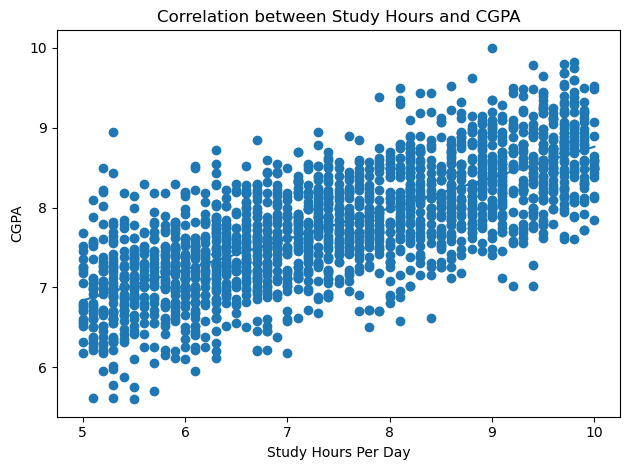

In [13]:
pdf = pd.read_csv("student_lifestyle_dataset.csv")
plt.figure()
plt.scatter(pdf['Study_Hours_Per_Day'], pdf['Grades'])
coeffs = np.polyfit(pdf['Study_Hours_Per_Day'], pdf['Grades'], 1)
x_vals = np.array([pdf['Study_Hours_Per_Day'].min(), pdf['Study_Hours_Per_Day'].max()])
y_vals = coeffs[0] * x_vals + coeffs[1]
plt.plot(x_vals, y_vals)
plt.xlabel('Study Hours Per Day')
plt.ylabel('CGPA')
plt.title('Correlation between Study Hours and CGPA')
plt.tight_layout()
plt.show()

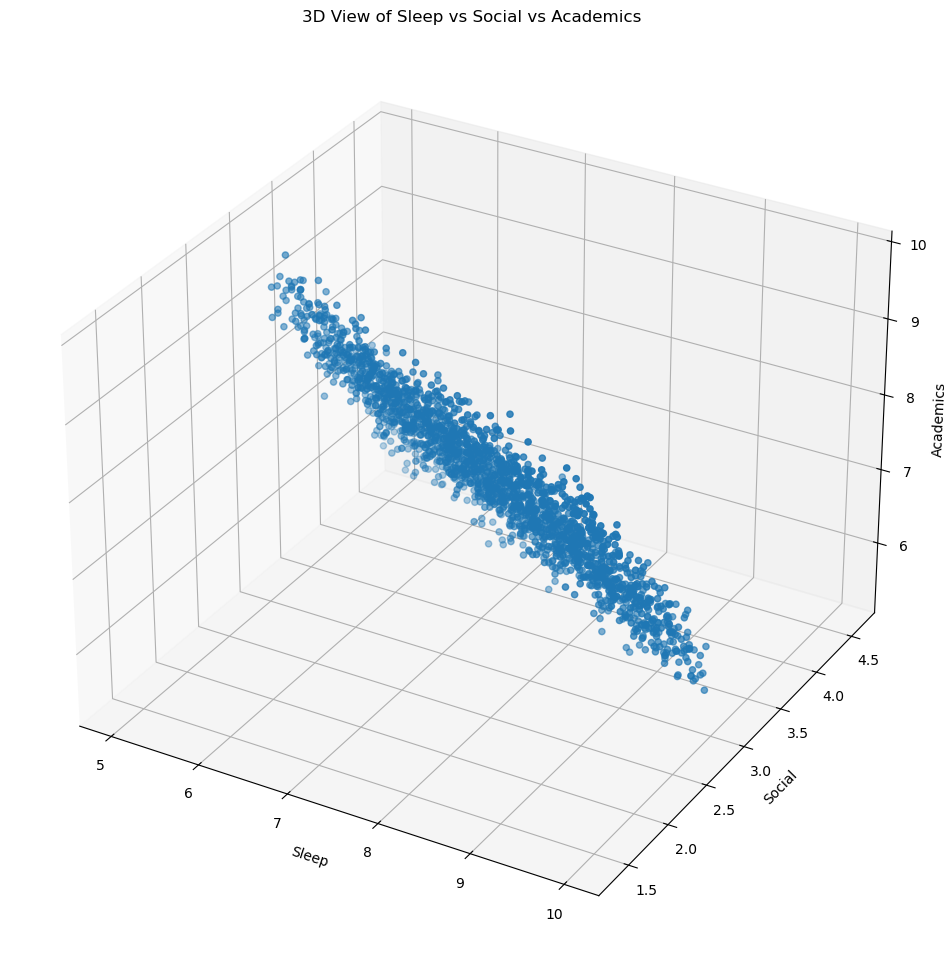

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_df_scores['Sleep_Score'], p_df_scores['Social_Score'], p_df_scores['Academics_Score'])

ax.set_xlabel('Sleep')
ax.set_ylabel('Social')
ax.set_zlabel('Academics')
plt.title("3D View of Sleep vs Social vs Academics")
plt.show()